### Want to see: 
- Still looking at change in neural activity projected onto preference axes
- Is the magnitude of this projection different for different belief partitions?
- Prediction for chose X, correct: 
  - low: larger
  - High X: lower, maybe negative
  - High not X: lower
- Prediction for chose X, incorrect: 
  - low, lower
  - High X: large negative 
  - High not X: lower




In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.visualization_utils as visualization_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
import utils.classifier_utils as classifier_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
from constants.behavioral_constants import *
from constants.decoding_constants import *
from scripts.pseudo_decoding.belief_partitions.belief_partition_configs import *
import scripts.pseudo_decoding.belief_partitions.belief_partitions_io as belief_partitions_io
import itertools

import argparse
import copy
from tqdm import tqdm
import seaborn as sns
import utils.stats_utils as stats_utils

In [38]:
# conditions_maps = {
#     "chose X / correct": {"Response": "Correct", "Choice": "Chose"},
#     "chose X / incorrect": {"Response": "Incorrect", "Choice": "Chose"},
#     "correct": {"Response": "Correct"},
#     "incorrect": {"Response": "Incorrect"},
# }

# conditions_maps = {
#     "chose X / incorrect / low": {"Response": "Incorrect", "Choice": "Chose", "BeliefPartition": "Low"},
#     "chose X / incorrect / high X": {"Response": "Incorrect", "Choice": "Chose", "BeliefPartition": "High X"},
#     "chose X / incorrect / high not X": {"Response": "Incorrect", "Choice": "Chose", "BeliefPartition": "High Not X"},
#     "chose X / correct / low": {"Response": "Correct", "Choice": "Chose", "BeliefPartition": "Low"},
#     "chose X / correct / high X": {"Response": "Correct", "Choice": "Chose", "BeliefPartition": "High X"},
#     "chose X / correct / high not X": {"Response": "Correct", "Choice": "Chose", "BeliefPartition": "High Not X"},
#     # "correct": {"Response": "Correct"},
#     # "incorrect": {"Response": "Incorrect"},
# }

conditions_maps = {
    # "chose X / correct": {"Response": "Correct", "Choice": "Chose"},
    # "chose X / incorrect": {"Response": "Incorrect", "Choice": "Chose"},
    # "correct": {"Response": "Correct"},
    # "incorrect": {"Response": "Incorrect"},
    "chose X / incorrect / low": {"Response": "Incorrect", "Choice": "Chose", "BeliefPartition": "Low"},
    "chose X / incorrect / high X": {"Response": "Incorrect", "Choice": "Chose", "BeliefPartition": "High X"},
    "chose X / incorrect / high not X": {"Response": "Incorrect", "Choice": "Chose", "BeliefPartition": "High Not X"},
    "chose X / correct / low": {"Response": "Correct", "Choice": "Chose", "BeliefPartition": "Low"},
    "chose X / correct / high X": {"Response": "Correct", "Choice": "Chose", "BeliefPartition": "High X"},
    "chose X / correct / high not X": {"Response": "Correct", "Choice": "Chose", "BeliefPartition": "High Not X"},
}



def read_all_cond_data(args):
    all_data = []
    # for i, event in enumerate(["StimOnset", "FeedbackOnsetLong"]):
    for i, event in enumerate(["StimOnset"]):
        all_conds = []
        for cond_name in conditions_maps:
            args.trial_event = event
            args.conditions = conditions_maps[cond_name]
            res = belief_partitions_io.read_update_projections(args)
            res["cond"] = res.apply(lambda x: f"shuffle" if "shuffle" in x["mode"] else cond_name, axis=1)
            all_conds.append(res)
        all_conds = pd.concat(all_conds)
        all_conds["trial_event"] = event
        all_conds["Time"] = all_conds["TimeIdx"] / 10
        all_data.append(all_conds)
    return pd.concat(all_data)

In [39]:
args = argparse.Namespace(
    **BeliefPartitionConfigs()._asdict()
)
args.subject = "both"
# args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.base_output_path = "/data/patrick_res/update_projections"
args.mode = "pref"
# args.sig_unit_level = f"{args.mode}_99th_window_filter_drift"
args.sig_unit_level = f"{args.mode}_99th_no_cond_window_filter_drift"
args.trial_event = "StimOnset"

# args.region_level = "structure_level2_cleaned"
# args.


In [40]:
res = read_all_cond_data(args)
res = res[res.Time <0]

In [37]:
belief_partitions_io.read_update_projections_pvals(args, conditions_maps, axis_vars=["pref"])

,cond,var,p
0,chose X / correct,pref,0.000
1,chose X / incorrect,pref,0.113
2,correct,pref,0.858
3,incorrect,pref,0.228
4,chose X / incorrect / low,pref,0.000
5,chose X / incorrect / high X,pref,0.000
6,chose X / incorrect / high not X,pref,0.000
7,chose X / correct / low,pref,0.000
8,chose X / correct / high X,pref,0.129
9,chose X / correct / high not X,pref,0.235


### Are the shuffles actually different? 

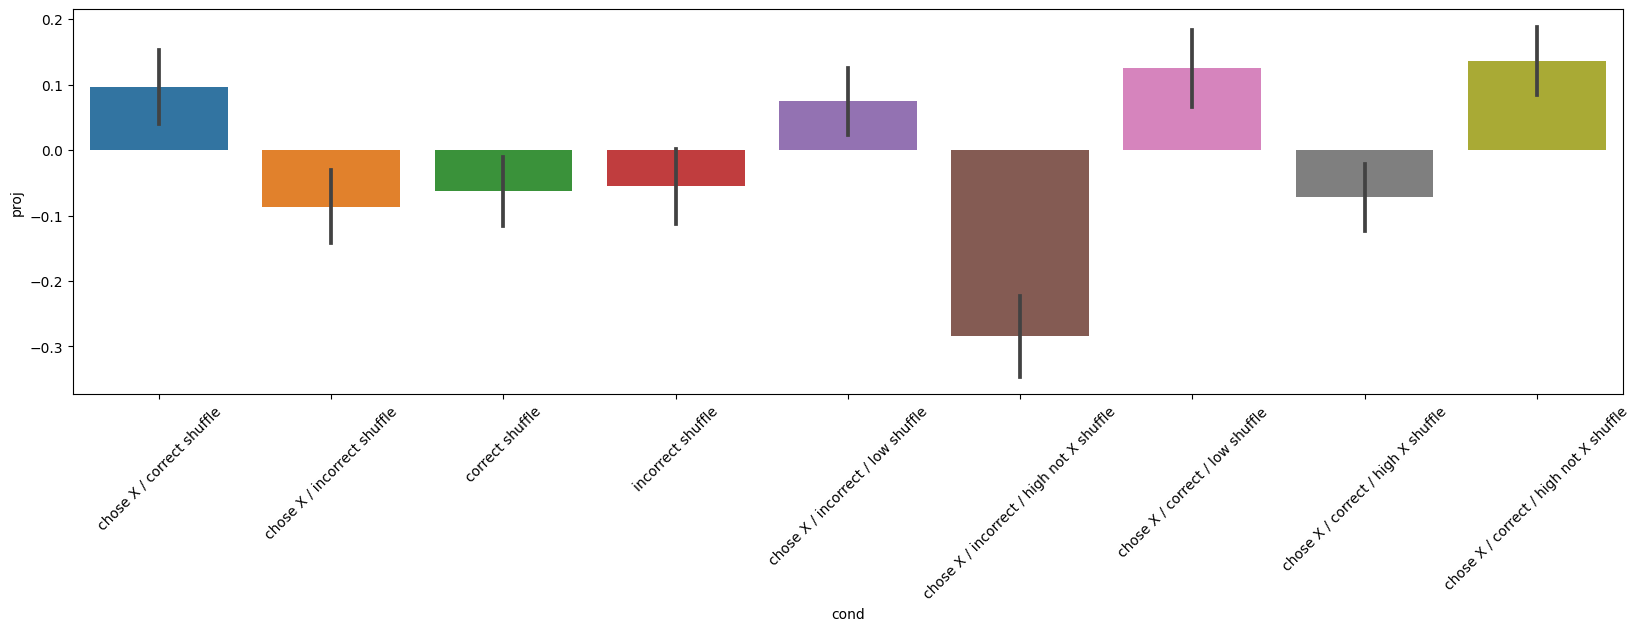

In [6]:
shuffs = res[res.cond.str.contains("shuffle")]
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(shuffs, x="cond", y="proj", errorbar="se", ax=ax)
ax.tick_params(axis='x', labelrotation=45)

In [7]:
shuffs.proj.mean()

-0.014267452510776999

In [15]:
res["cond"].unique()

array(['chose X / correct', 'chose X / correct shuffle',
       'chose X / incorrect', 'chose X / incorrect shuffle', 'correct',
       'correct shuffle', 'incorrect', 'incorrect shuffle',
       'chose X / incorrect / low', 'chose X / incorrect / low shuffle',
       'chose X / incorrect / high not X',
       'chose X / incorrect / high not X shuffle',
       'chose X / correct / low', 'chose X / correct / low shuffle',
       'chose X / correct / high X', 'chose X / correct / high X shuffle',
       'chose X / correct / high not X',
       'chose X / correct / high not X shuffle'], dtype=object)

In [16]:
res["cond"] = res["cond"].apply(lambda x: "shuffle" if "shuffle" in x else x)


In [17]:
res["cond"].unique()

array(['chose X / correct', 'shuffle', 'chose X / incorrect', 'correct',
       'incorrect', 'chose X / incorrect / low',
       'chose X / incorrect / high not X', 'chose X / correct / low',
       'chose X / correct / high X', 'chose X / correct / high not X'],
      dtype=object)

### Verify chose/cor and chose/inc effects are largest

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='cond', ylabel='proj'>)

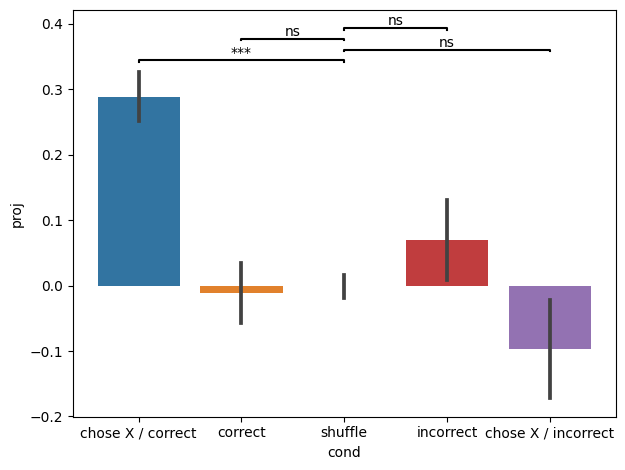

In [33]:
# res["cond"] = res["cond"].apply(lambda x: "shuffle" if "shuffle" in x else x)

order= ["chose X / correct", "correct", "shuffle", "incorrect", "chose X / incorrect"]
res = res[res.cond.isin(["chose X / correct", "correct", "shuffle", "incorrect", "chose X / incorrect"])]
res = res.sort_values(by="cond", key=lambda x: x.map(order.index))
fig, ax = plt.subplots()
sns.barplot(res, x="cond", y="proj", errorbar="se", ax=ax)
visualization_utils.add_significance_bars(fig, ax, res, "cond", "proj", pairs=[
    ("chose X / correct", "shuffle"),
    ("chose X / incorrect", "shuffle"),
    ("correct", "shuffle"),
    ("incorrect", "shuffle"),
], 
# test=stats_utils.get_permutation_test_func(test_type="two_side")
)

In [41]:
# sub_res = res[~((res.trial_event == "FeedbackOnsetLong") & (res.Time > 0))]
# sub_res = res[~((res.trial_event == "StimOnset") & (res.Time < 0))]
# sub_res = res[~((res.trial_event == "FeedbackOnsetLong") & (res.Time > 0))]

sub_res = res

In [42]:
cor_res = sub_res[~sub_res.cond.str.contains("incorrect")]
inc_res = sub_res[~sub_res.cond.str.contains(" correct")]

(<Figure size 1000x1000 with 2 Axes>, <Axes: xlabel='cond', ylabel='proj'>)

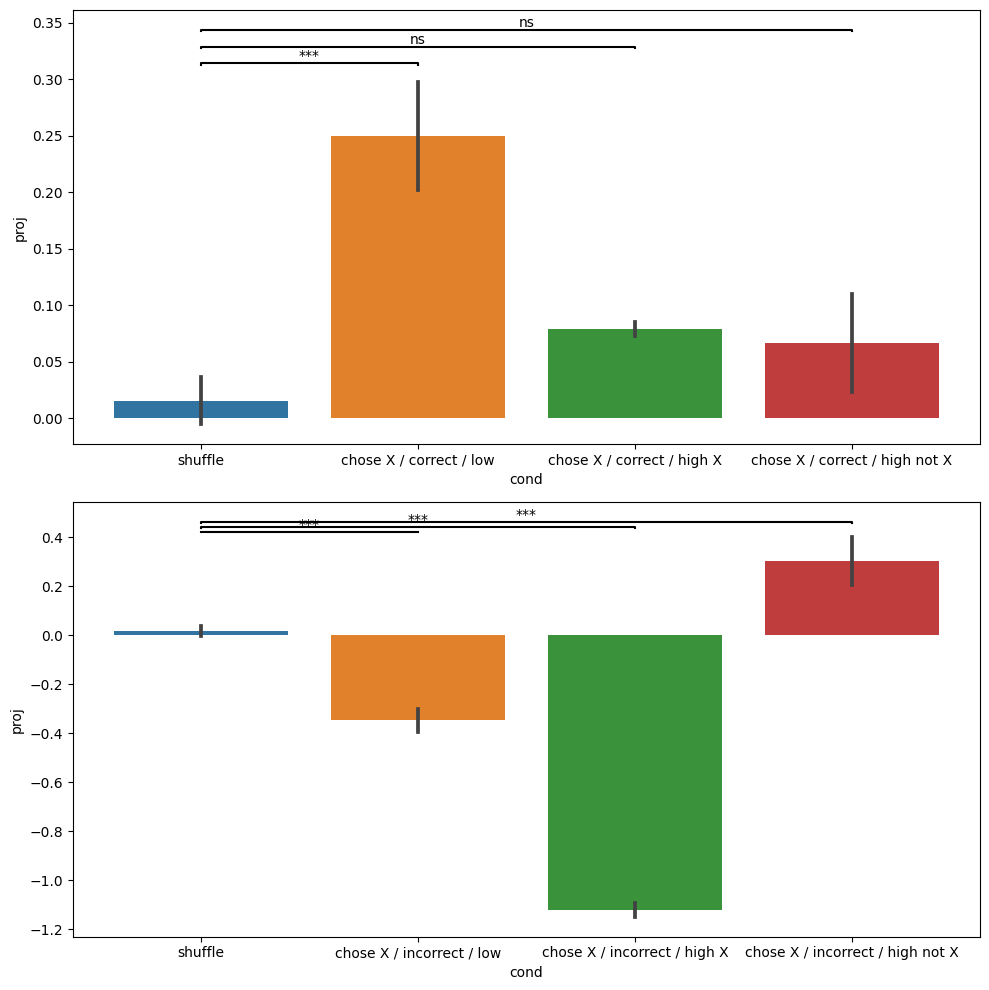

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

cor_order= ["shuffle", "chose X / correct / low", "chose X / correct / high X", "chose X / correct / high not X"]
cor_res = cor_res.sort_values(by="cond", key=lambda x: x.map(cor_order.index))
sns.barplot(cor_res, x="cond", y="proj", errorbar="se", ax=ax1, order=cor_order)
visualization_utils.add_significance_bars(
    fig, ax1, cor_res, "cond", "proj", pairs=[
        ("chose X / correct / low", "shuffle"),
        ("chose X / correct / high X", "shuffle"),
        ("chose X / correct / high not X", "shuffle"),
    ], 
    # test=stats_utils.permutation_test_wrapper
)

inc_order= ["shuffle", "chose X / incorrect / low", "chose X / incorrect / high X", "chose X / incorrect / high not X"]
inc_res = inc_res.sort_values(by="cond", key=lambda x: x.map(inc_order.index))
sns.barplot(inc_res, x="cond", y="proj", errorbar="se", ax=ax2, order=inc_order)
visualization_utils.add_significance_bars(
    fig, ax2, inc_res, "cond", "proj", 
    pairs=[
        ("chose X / incorrect / low", "shuffle"),
        ("chose X / incorrect / high X", "shuffle"),
        ("chose X / incorrect / high not X", "shuffle"),
    ], 
    # test=stats_utils.permutation_test_wrapper
)


### scrap

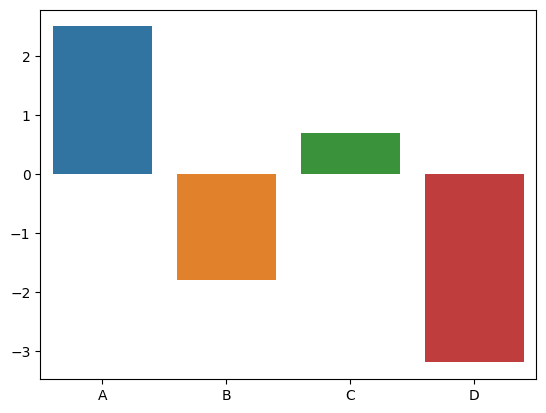

In [3]:
import seaborn as sns, matplotlib.pyplot as plt

data = dict(category=["A","B","C","D"], value=[2.5, -1.8, 0.7, -3.2])
palette = {
    "A": "#1f77b4ff",  # opaque
    "B": "#ff7f0eff",  # opaque
    "C": "#2ca02c80",  # 50% alpha
    "D": "#d6272880"   # 50% alpha
}

ax = sns.barplot(x="category", y="value", data=data, palette=palette)
plt.show()
